# Quantum Optimization with Qiskit Patterns

In this how-to we will learn about Qiskit Patterns and quantum approximate optimization. Qiskit Patterns define a four-step process for running algorithms on a quantum computer:


<img src="imgs/patterns.png" alt="Drawing" style="float: left; width: 200px;"/>


            1. Map classical problem to abstract quantum circuits and operators
            2. Optimize problem for quantum execution
            3. Execute on a quantum computer
            4. Post-process, return result in classical format

We will apply the patterns to the context of **combinatorial optimization** and show how to solve the **Max-Cut** problem using the **Quantum Approximate Optimization Algorithm (QAOA)**, a hybrid (quantum-classical) iterative method. 

# Part 1: (Small-scale) Qiskit Pattern for Optimization

The first part of the session will use a small-scale Max-Cut problem to ilustrate the steps required to solve an optimization problem using a quantum computer.

Max-Cut is a hard to solve optimization problem with applications in clustering, network science, and statistical physics. In Max-Cut, we want to partition the nodes of a graph into to sets such that the number of edges traversed by this cut is maximum.

<img src="imgs/max-cut.png" alt="Max-Cut"/>

The workflow starts with a problem defined as a weighted graph:

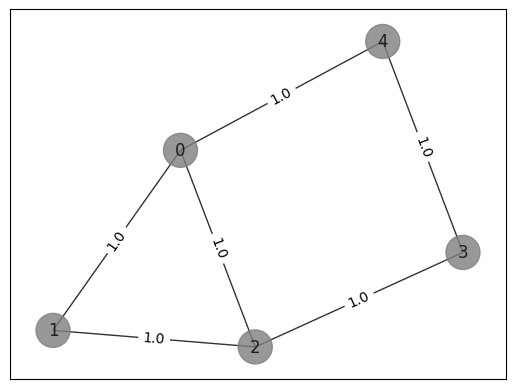

In [18]:
from demo_src.graph import generate_demo_graph, draw_graph

demo_graph = generate_demo_graph()
draw_graph(demo_graph)

Formally, it's an example of a classical combinatorial optimization problem with the form

\begin{align}
\min_{x\in \{0, 1\}^n}f(x)
\end{align}

Where the vector $x$ are the $n$ decision variables that correspond to every node of the graph. In this case, we have $n=5$, and each node can be 0 or 1, included or not included in the cut. The minimum of $f(x)$ in this case will be when the number of edges traversed by the cut are maximal.

As you can see, there is nothing relating to quantum computing yet. We need to reformulate this problem into something that a quantum computer can understand.

## Step 1. Map the classical inputs to a quantum problem

### Graph &rarr; Qubo

The first step of the mapping is a notation change, can express our problem in Quadratic Unconstrained Binary Optimization notation:

\begin{align}
\min_{x\in \{0, 1\}^n}x^T Q x,
\end{align}

where $Q$ is a $n\times n$ matrix of real numbers. 

In [19]:
from demo_src.map import map_graph_to_qubo

qubo = map_graph_to_qubo(demo_graph)
print(qubo.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 + 3*x_0
  + 2*x_1 + 3*x_2 + 2*x_3 + 2*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



### QUBO &rarr; Ising Hamiltonian

To start, we will convert the binary variables $x_i$ to variables $z_i\in\{-1, 1\}$ by doing

\begin{align}
x_i = \frac{1-z_i}{2}.
\end{align}

Here, for example, we see that if $x_i$ is $0$ then $z_i$ is $1$. When we substitute the $x_i$'s for the $z_i$'s in the QUBO above, we obtain the equivalent formulations for our optimization task

\begin{align}
\min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

The details of the computation are shown in Appendix A below. Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped an irrelevant factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization. Now, to obtain a quantum formulation of the problem we promot the $z_i$ variables to a Pauli $Z$ matrix, i.e., a $2\times 2$ matrix of the form

\begin{align}
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
\end{align}

When we substitute these matrices in the QUBO above we obtain the following Hamiltonian

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}

We refer to this Hamiltonian as the **cost function Hamiltonian**. It has the property that its gound state corresponds to the solution that **minimizes the cost function $f(x)$**.
Therefore, to solve our optimization problem we now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min f(x)$.

In [20]:
from demo_src.map import map_qubo_to_ising

cost_hamiltonian, offset = map_qubo_to_ising(qubo)
print("Offset:", offset)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Offset: -3.0
Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### Ising Hamiltonian &rarr; Quantum Circuit

The Hamiltonian $H_c$ obtained from step 1 contains the quantum definition of our problem. We will now create a quantum circuit that will help us *sample* good solutions form the quantum computer. The QAOA is inspired from quantum annealing and proceeds by applying alternating layers of operators in the quantum cirucit.

[image]

Losely speaking, the idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that we are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with the right angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$. 

We can generate a quantum circuit  that is **parametrized** by these angles. In this case we will try an example with 1 QAOA layer that contains two parameters: $\gamma_0$ and $\beta_0$.

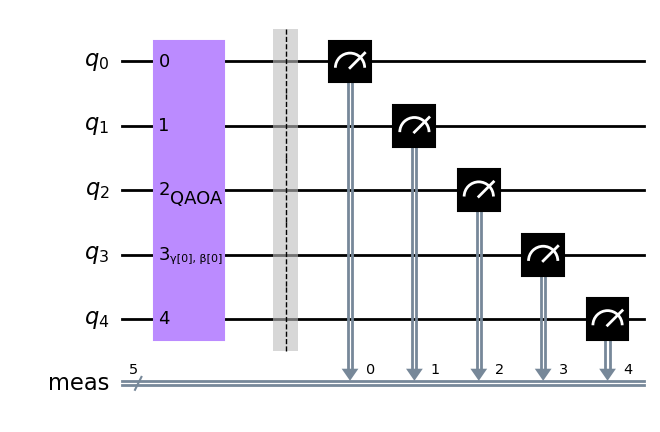

In [21]:
from demo_src.map import map_ising_to_circuit

circuit = map_ising_to_circuit(cost_hamiltonian, num_layers=1)
circuit.draw('mpl')

## Step 2. Optimize problem for quantum execution

The circuit above contains a series of abstractions useful to think about quantum algorithms, but not possible to run in the hardware. To be able to run it in a quantum chip, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. We don't only want to get a circuit, but we want to make sure that the circuit is **optimized** for our purpose. Transpilation may involve many steps, such as:

* **Intiall mapping** of the qubits in the circuit (i.e. decision variables) to physical qubits on the device.
* **Unrolling** of the instructions in the quantum circuit to the hardware native instructions that the backend understands.
* **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
* **Error supression** by adding single-qubit gates to supress noise with dynamical decoupling.
* ...

In this example, we have encapsulated a series of transpilation passes in the `optimize_circuit` function. The function takes a circuit and a backend (device) and returns an optimized circuit ready to run in the corresponding device:

In [22]:
# IBM Quantum devices are named after cities
# For the purpose of the first part of this demo, we will
# use a simulated device from the "fake_provider"
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
backend = FakeVigoV2()

from demo_src.transpile import optimize_circuit
opt_circuit = optimize_circuit(circuit, backend)
opt_circuit.draw('mpl', fold=False)

ModuleNotFoundError: No module named 'qiskit_ibm_runtime.fake_provider'

## Step 3. Execute using Qiskit Runtime primitives

In the general QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, where we run a series of circuit evaluations and use a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. In this demo, we will not optimize these parameters, we will simply assume that someone has done this for us. Note that finding such parameters is a research field in itself.

Once the optimal parameters are defined, we want to perform one final sampling with the resulting circuit to find our candidate solution.

This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state, for example `010101110000...` which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).

The execution is done through the **cloud** using the **Qiskit IBM Runtime service**.

### Define circuit with optimal parameters

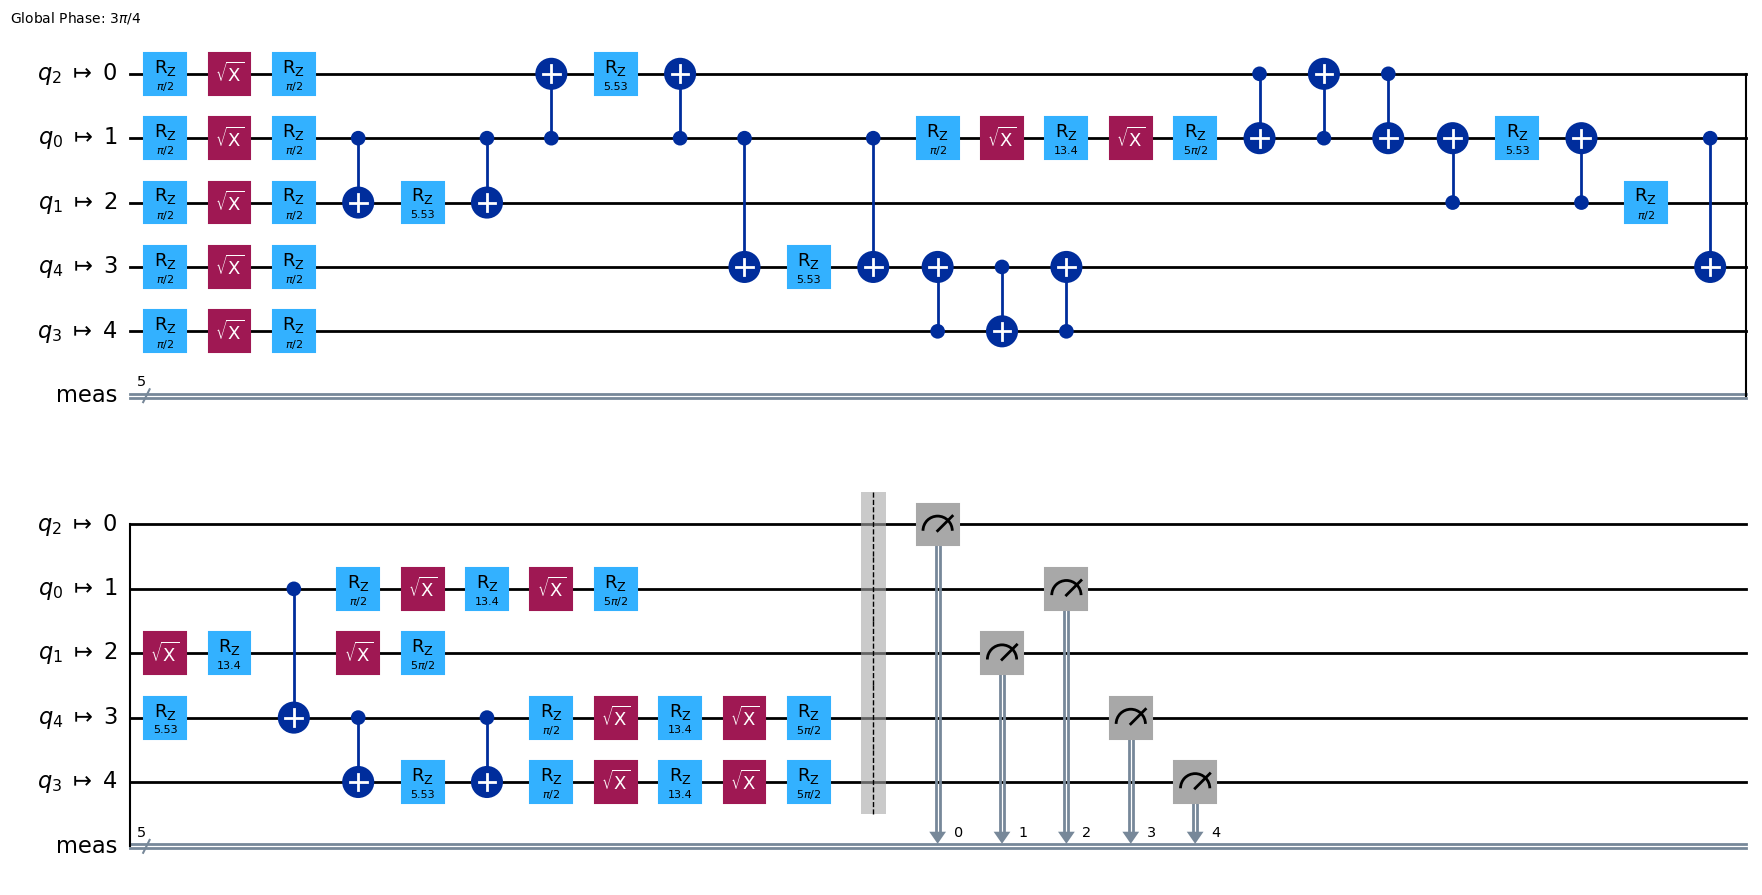

In [6]:
optimal_gamma = 5.11350346
optimal_beta = 5.52673212

candidate_circuit = opt_circuit.assign_parameters([optimal_gamma, optimal_beta])
candidate_circuit.draw('mpl', fold=False)

### Define backend and execution primitive

To interact with a IBM backends we use the **Qiskit Runtime Primitives**. There are two primitives: Sampler and Estimator, and the choice of primitive depends on the task that we want to run on the quantum computer. We are interested in drawing samples from the quantum computer, so we will use the **Sampler**. 

In [7]:
# For the purpose of the first part of this demo, we will
# use a simulated device from the "fake_provider"
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.primitives import BackendSampler

backend = FakeVigoV2()
sampler = BackendSampler(backend=backend)

### Run

In [8]:
final_distribution = sampler.run(candidate_circuit, shots=int(1e4)).result().quasi_dists[0]
print(final_distribution)

{0: 0.0069, 24: 0.0068, 31: 0.0058, 28: 0.0142, 30: 0.0103, 15: 0.0176, 3: 0.0153, 5: 0.0628, 21: 0.0445, 23: 0.019, 13: 0.0381, 14: 0.0232, 19: 0.029, 2: 0.0108, 10: 0.0489, 9: 0.0889, 27: 0.0173, 8: 0.0195, 17: 0.025, 7: 0.0093, 20: 0.088, 12: 0.0299, 4: 0.0173, 25: 0.014, 16: 0.0182, 29: 0.0095, 6: 0.0173, 22: 0.0844, 18: 0.0412, 11: 0.09, 1: 0.016, 26: 0.061}


## Step 4. Post-process, return result in classical format

In [9]:
from demo_src.post import sample_most_likely

best_result = sample_most_likely(final_distribution, len(demo_graph))
print("Result bitstring:", best_result)

Result bitstring: [1 1 0 1 0]


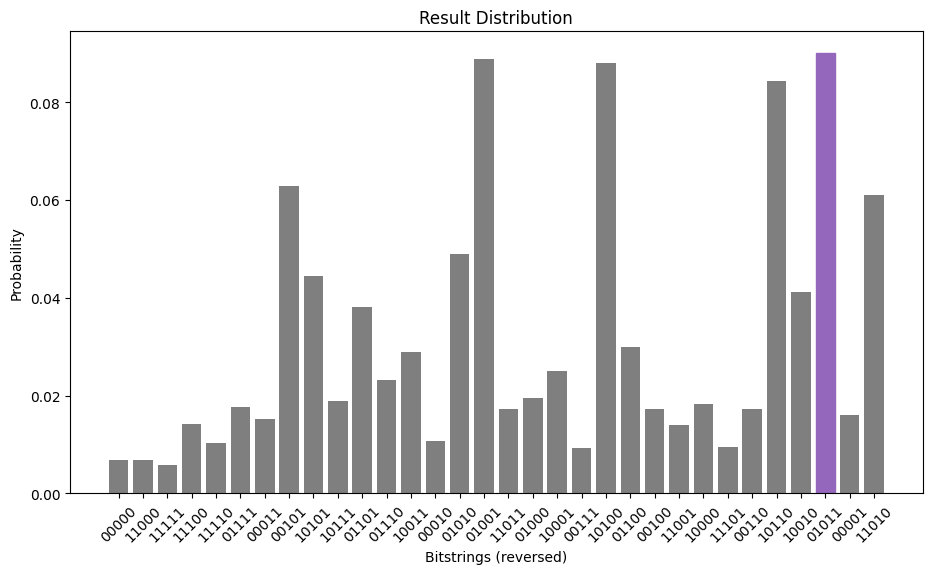

In [10]:
from demo_src.post import plot_distribution

plot_distribution(final_distribution)

### Visualize best cut

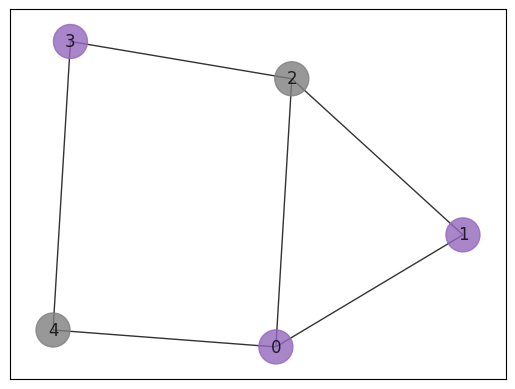

In [11]:
from demo_src.post import plot_result

plot_result(demo_graph, best_result)

---

# Part 2: Let's scale it up and run!

Let's try to solve Max-Cut on a 127-node weighted graph, with both positive (green) and negative (red) weights.

<div>
<img src="data/125node_example.png" width="500"/>
</div>

We have precomputed steps 1-3 for you, so you get to run step 4 on a real quantum device.

## Step 1. Map the classical inputs to a quantum problem

### Graph &rarr; QUBO

The cell below shows you what the LP file that stores the quadratic program for this problem looks like.

In [12]:
with open("data/125node_example.lp", "r") as file:
    problem = file.read()
print(problem)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 8 x0^2 + 8 x0*x1 + 8 x0*x13 - 8 x1^2 + 8 x1*x2 - 8 x2*x3 + 8 x3*x4
      - 4 x4^2 - 8 x4*x5 + 8 x4*x14 + 8 x5*x6 - 8 x6^2 + 8 x6*x7 - 8 x7^2
      + 8 x7*x8 - 12 x8^2 + 8 x8*x9 + 8 x8*x15 - 8 x9*x10 + 8 x10^2 - 8 x10*x11
      + 8 x11*x12 - 8 x12*x16 - 8 x13*x17 - 8 x14*x21 - 8 x15*x25 + 8 x16^2
      - 8 x16*x29 + 8 x17*x18 - 8 x18^2 + 8 x18*x19 + 4 x19^2 - 8 x19*x20
      - 8 x19*x32 + 8 x20*x21 - 4 x21^2 + 8 x21*x22 - 8 x22^2 + 8 x22*x23
      - 12 x23^2 + 8 x23*x24 + 8 x23*x33 - 8 x24^2 + 8 x24*x25 + 4 x25^2
      - 8 x25*x26 + 8 x26*x27 - 4 x27^2 + 8 x27*x28 - 8 x27*x34 - 8 x28*x29
      + 12 x29^2 - 8 x29*x30 + 8 x30^2 - 8 x30*x31 + 8 x31^2 - 8 x31*x35
      + 8 x32*x38 - 8 x33*x42 + 8 x34^2 - 8 x34*x46 + 8 x35^2 - 8 x35*x50
      - 8 x36^2 + 8 x36*x37 + 8 x36*x51 - 8 x37*x38 - 4 x38^2 + 8 x38*x39
      - 8 x39*x40 + 12 x40^2 - 8 x40*x41 - 8 x40*x52 + 8 x41^2 - 8 x41*x42
     

### QUBO &rarr; Hamiltonian

Below we show the first 10 Pauli terms in the cost-function Hamiltonian. They look similar, but pay attention to the `Z` and the coefficients which correspond to the weight of the edges in the graph for which we want to find the maximum cut.

In [13]:
with open("data/125node_example_ising.txt") as input_file:
    for _ in range(10):
        print(str(next(input_file)).replace("\n", ""))

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII, -1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII, -1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 2. Optimize problem for quantum execution

We have prepared the optimized circuits for you. These are stored in LP files that we can import with Qiskit's serializer named QPY.

In [12]:
from qiskit import qpy  # QPY is the circuit serializer in Qiskit.

# Load the circuits
team = 1  # Fill in your team here, either 1 or 2
if team == 1:
    backend_type = "eagle"
elif team == 2:
    backend_type == "heron"
else:
    raise ValueError("team should be 1 or 2.")

# Depth zero-circuit
with open(f"data/125node_{backend_type}_depth_zero.qpy", "rb") as fd:
    depth_zero_circuit = qpy.load(fd)[0]

# Depth one-circuit
with open(f"data/125node_{backend_type}_depth_one.qpy", "rb") as fd:
    depth_one_circuit = qpy.load(fd)[0]

You can print the circuit by uncommenting the line below. However, note that the output for utility-scale experiments is typically large.

In [8]:
#print(depth_one_circuit)

## Step 3. Execute using Qiskit Runtime Primitives

To run QAOA we need to know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. We will not optimize these parameters here. We will simply assume that someone has done this for us. The optimal parameters to use are

* Depth-zero QAOA: none
* Depth-one optimal (gamma, beta): (0.3792, 0.3792)

Note that findin gsuch parameters is a research field in itself.

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Backend for team 1
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend('ibm_sherbrooke')

# Backend for team 2
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend('ibm_torino')

In [10]:
from qiskit_ibm_runtime import Sampler, Options

# Since we have already done the transpilation we can skip it.
options = Options()
options.transpilation.skip_transpilation = True

sampler = Sampler(backend=backend, options=options)

### Bind the parameters for the depth-one ansatz

As mentioned above, the depth-one QAOA circuit has two parameters $\gamma$ and $\beta$ that need to be bound before we can run the circuits.

In [13]:
depth_one_circuit.parameters

ParameterView([Parameter(β1), Parameter(γ1)])

We create a circuit with bound parameter values below.

In [14]:
depth_one_bound_circuit = depth_one_circuit.assign_parameters([0.3927,  0.3927], inplace=False)

### Sample candidate solution from backend

In [15]:
sampler_job = sampler.run([depth_one_bound_circuit, depth_zero_circuit])

Each call to the sampler returns a JobId that we can use to retrive the results when they are ready.

In [16]:
sampler_job.job_id()

'cqc945rvxaq00083e690'

In addition, we can check the status of our jobs to see if they are finished.

In [17]:
sampler_job.status()

<JobStatus.QUEUED: 'job is queued'>

Now, we will locally save the samples that the backend returned so that we can share them and later analyze them.

In [ ]:
from demo_src.run import save_result

save_result(sampler_job.result(), backend_type, path="sampler_data")

## Step 4. Post-process, return result in classical format

Now, we need to compute the objective value of each sample that we measured on the quantum computer. The best one will be the solution returned by the quantum computer.

In [1]:
from demo_src.post import load_data, samples_to_objective_values, load_qp, plot_cdf

import matplotlib.pyplot as plt

In [3]:
qp, max_cut, min_cut = load_qp()

The following cell will load all the data that we have gathered. Note that we give it `qp`, the quadratic program of the MaxCut optimization problem, so that `load_data` can directly convert the samples to the value of the objective function.

In [2]:
depth_one_heron, depth_zero_heron, depth_one_eagle, depth_zero_eagle = load_data(qp)

Now, in the last cell we will display the cumulative distribution function of the sampled solutions for depth-zero QAOA (blue line) and depth-one QAOA (orange line). The dashed orange line displays the best sampled solution from the quantum computer. The black dashed line is the optimal solution. We can see that there is still a gap between the best sampled solution and the optimal solution. To get better solutions we would need to use deeper QAOA circuits. But be careful, this might result in more noise.

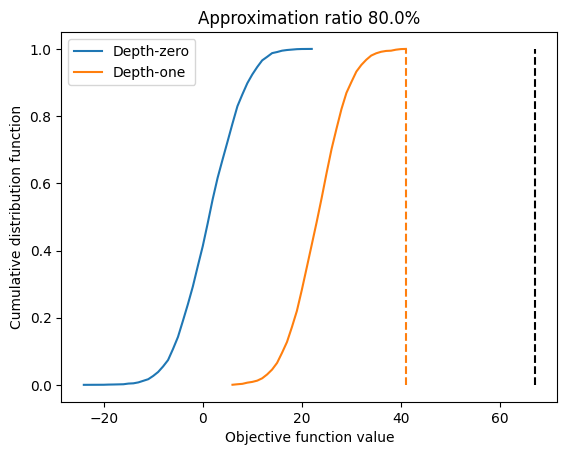

In [7]:
fig, ax = plt.subplots(1, 1)
plot_cdf(depth_zero_eagle, ax, "Depth-zero")
plot_cdf(depth_one_eagle, ax, "Depth-one")
ax.vlines(max_cut, 0, 1, "k", linestyle="--")
ax.vlines(max(list(depth_one_eagle.keys())), 0, 1, "C1", linestyle="--")
approx = 100 * (max(list(depth_one_eagle.keys())) - min_cut) / (max_cut - min_cut)
ax.set_title(f"Approximation ratio {approx}%")
ax.set_xlabel("Objective function value")
ax.set_ylabel("Cumulative distribution function")
ax.legend(loc=2);

## Conclusion

In this tutorial we present the Qiskit patterns and how to solve an optimization problem with a quantum computer. We demonstrate this at utility-scale, i.e., using on the order of 100 qubits. Currently, quantum computers do not outperform classical computers for combinatorial optimization. They are currently too noisy. However, the hardware is getting better and better and new algorithms for quantum computers are always being developped. This is also where the era of utility will be important. Indeed, much of the research working on quantum heuristics for combinatorial optimization are tested with classical simulations which only allow for a small number of qubits, typically aroud 20 qubits. Now, with larger qubit counts and devices with less noise we will be able to start benchmarking these quantum heuristics at large problem sizes on actual quantum hardware.

## Appendix A: Reformulation in spin variables

Here, we rewrite the QUBO $x^TQx$ in terms of spin-variables $x_i=(1-z_i)/2$.
\begin{align}
x^TQx=\sum_{ij}Q_{ij}x_ix_j=\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j)=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
\end{align}
If we write $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$ and remove the prefactor and the constant $n^2$ term we arrive at the two equivalent formulations of the same optimization problem
\begin{align}
\max_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \max_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

## Appendix B: Quantum notation

The $Z$ matrices are imbedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ imbedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.